# Group 13 Project Report

# Credit Score Classification

In [1]:
pip install -U altair

Note: you may need to restart the kernel to use updated packages.


**Introduction:**
A credit report is a summary of a person’s credit history and is created when you borrow money or apply for a credit card. A credit score is a 3 digit number calculated based on your credit report that summarizes how well you manage your credit and how risky it would be for someone to lend you money. The higher credit score the better your rating is.


A credit score is calculated based on a few different factors such as:
- a person's anual income
- the number of credit cards they have
- the number of loans they have
- their credit card payment history
- how old their credit is

and more



**The Question we aim to answer:** Can we classify someone’s credit score based on banking history and financial traits like the number of delayed payments and the amount of delay in paying their credit card bill? 

**Dataset description:** The dataset contains the bank and credit-related information of many individuals that have been amassed by a global finance company. It contains 27 columns of these information such as bank account history, loans, debt and EMI along with the number of credit cards a person has and their credit card payment history

**Dataset source:** https://www.kaggle.com/datasets/parisrohan/credit-score-classification/data 
 


In [2]:
import random
import altair as alt
import pandas as pd
import numpy as np
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_validate

np.random.seed(999) # setting the seed

### Reading the data from a URL

We uploaded the dataset to GitHub so we could read it directly from a URL

The public dataset we chose already had a split between the training data and test data, however, we wanted to experiment with different values of a train/test split and decided to only use the training dataset and perform the train/test split ourselves for our classification model.

In [3]:
url_credit = "https://raw.githubusercontent.com/vedika37/dsci100-proj/main/train.csv"
credit = pd.read_csv(url_credit,sep = ",", low_memory=False)
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

As we can see from the output of credit.info() the number of non-null observations are not the same across all variables, so to be able to analyze patterns in our data, we will first have to do some data cleaning. 

### Cleaning Data 

In [4]:
# dropping null values and columns not used in analysis

# Predictors:

# - number of delayed payments 
# - delay from due date 

credit = credit[['Num_of_Delayed_Payment', 'Delay_from_due_date', 'Credit_Score']]
credit = credit.dropna()
credit.head()

,Num_of_Delayed_Payment,Delay_from_due_date,Credit_Score
0,7,3,Good
2,7,3,Good
3,4,5,Good
5,4,8,Good
6,8_,3,Good


In [5]:
credit["Credit_Score"].unique()

array(['Good', 'Standard', 'Poor'], dtype=object)

We see here that our output variable i.e the credit score takes three unique values -> Good, Standard and Poor.

In [6]:
# cleaning Num_of_Delayed_Payment and keeping it to integer values to use in our analysis
credit = credit[credit['Num_of_Delayed_Payment'].str.isdigit()]
credit.head()

,Num_of_Delayed_Payment,Delay_from_due_date,Credit_Score
0,7,3,Good
2,7,3,Good
3,4,5,Good
5,4,8,Good
7,6,3,Standard


In [7]:
credit= credit.astype({'Num_of_Delayed_Payment': int})


### Summarizing Data

In [8]:
# each column along with its datatype
credit.dtypes

Num_of_Delayed_Payment     int64
Delay_from_due_date        int64
Credit_Score              object
dtype: object

In [9]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89632 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Num_of_Delayed_Payment  89632 non-null  int64 
 1   Delay_from_due_date     89632 non-null  int64 
 2   Credit_Score            89632 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.7+ MB


In [10]:
# generating descriptive statistics for numeric and 'object' type columns
credit.describe()

,Num_of_Delayed_Payment,Delay_from_due_date
count,89632.000000,89632.000000
mean,31.259863,21.175328
std,227.725486,14.864670
min,0.000000,-5.000000
25%,9.000000,10.000000
50%,14.000000,18.000000
75%,18.000000,28.000000
max,4397.000000,67.000000


### Taking a Random Sample

In [11]:
credit['Credit_Score'].value_counts(normalize=True)

Standard    0.532366
Poor        0.291693
Good        0.175942
Name: Credit_Score, dtype: float64

In [12]:
credit_sample = credit.sample(n = 1000)
credit_sample['Credit_Score'].value_counts(normalize=True)

Standard    0.545
Poor        0.280
Good        0.175
Name: Credit_Score, dtype: float64

#### Impact Of Taking Subset of Data

We have limited our sample size to 1,000 observations, despite the original dataset containing over 80,000 entries. Training our model on the full dataset might yield more representative results, but this approach demands significant computational resources and time. To mitigate this, we've ensured that the proportions of output categories in our sample closely mirror those in the original dataset, thus minimizing the risk of bias in our results. However, it's notable that the 'standard' category constitutes approximately 53.3% of our sample outputs. This could suggest a sampling bias, a factor often beyond the control of data scientists and a potential limitation of our study. To further address this, we could consider selecting a dataset where all outputs are equally represented. However, this approach may not accurately reflect the actual population demographics, presenting a trade-off between balanced representation and real-world application.

### Train - Test Split 

In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    credit_sample, train_size=0.75, stratify=credit_sample["Credit_Score"]
)
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750 entries, 25469 to 14556
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Num_of_Delayed_Payment  750 non-null    int64 
 1   Delay_from_due_date     750 non-null    int64 
 2   Credit_Score            750 non-null    object
dtypes: int64(2), object(1)
memory usage: 23.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 28983 to 95411
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Num_of_Delayed_Payment  250 non-null    int64 
 1   Delay_from_due_date     250 non-null    int64 
 2   Credit_Score            250 non-null    object
dtypes: int64(2), object(1)
memory usage: 7.8+ KB
None


In [14]:
print("Value counts for training data\n",train["Credit_Score"].value_counts(normalize=True))
print("\nValue counts for testing data\n",test["Credit_Score"].value_counts(normalize=True))

Value counts for training data
 Standard    0.545333
Poor        0.280000
Good        0.174667
Name: Credit_Score, dtype: float64

Value counts for testing data
 Standard    0.544
Poor        0.280
Good        0.176
Name: Credit_Score, dtype: float64


### Visualizing Data - Distribution of Predictor Variables

In [15]:
# initializing list of predictors
predictors = ["Delay_from_due_date", "Num_of_Delayed_Payment"]

# visualizing training data

# removing outliers to make the visualization more naturak
def remove_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    return (column >= Q1 - 1.5 * IQR) & (column <= Q3 + 1.5 * IQR)

# Apply outlier removal to each column
for col in predictors:
    train_plot = train[remove_outliers(train[col])]

train_pairplot = alt.Chart(train_plot).mark_point(opacity=0.4).encode(
    alt.X(alt.repeat("row"), type="quantitative"),
    alt.Y(alt.repeat("column"), type="quantitative"),
    color = alt.Color("Credit_Score").title("Credit_Score")
).properties(
    width=200,
    height=200
).repeat(
    column=predictors,
    row=predictors
)

train_pairplot

alt.RepeatChart(...)

Delay from due date vs Num of delayed payments. We would expect to see a linaer relation between these two variables (generally speaking). Our expectations are met as seen in the visualization above. The two variables show a (weak) positive relation.

### Methods

We plan to conduct our data analysis using the K Nearest Neighbors Classification algrorithm. We'll choose the best value of k using cross-validation and then use the following predictors to predict whether someone's Credit Score is Good, Standard or Poor.

Predictors:

- number of delayed payments 
- delay from due date 
**Describing our visualizations**
We will plot histograms to visualize the distributions of our predictors. This will help us explore the relation between predicted credit score and the factors that may impact the credit score more than others like income, missed payments, credit utilization ratios.


In [16]:
# training_labels = subset_train["Credit_Score"]
# training_labels

In [17]:
knn = KNeighborsClassifier(n_neighbors=41)
knn

KNeighborsClassifier(n_neighbors=41)

In [18]:
preprocessor = make_column_transformer(
    (StandardScaler(), predictors),
    remainder='passthrough',
    verbose_feature_names_out=False
)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 ['Delay_from_due_date',
                                  'Num_of_Delayed_Payment'])],
                  verbose_feature_names_out=False)

In [19]:
X = train.drop(columns='Credit_Score')
y = train["Credit_Score"]

train_fit = make_pipeline(preprocessor, knn).fit(X, y)

train_fit

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['Delay_from_due_date',
                                                   'Num_of_Delayed_Payment'])],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=41))])

In [20]:
test_predictions = test.assign(
    predicted = train_fit.predict(test[predictors])
)
test_predictions.head()

,Num_of_Delayed_Payment,Delay_from_due_date,Credit_Score,predicted
28983,23,47,Standard,Poor
1431,20,25,Standard,Standard
27040,5,18,Standard,Standard
9783,1,11,Standard,Standard
29776,7,15,Standard,Standard


In [21]:
X_test = test[predictors]
y_test = test["Credit_Score"]
accuracy = train_fit.score(X_test,y_test)
accuracy

0.608

### Choosing the best K

In [22]:
param_grid = {
    "kneighborsclassifier__n_neighbors": range(1, 100, 5),
}
tune_pipe = make_pipeline(preprocessor, KNeighborsClassifier())

In [23]:
knn_tune_grid = GridSearchCV(
    estimator = tune_pipe, param_grid = param_grid, cv=25,
)
knn_tune_grid

GridSearchCV(cv=25,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['Delay_from_due_date',
                                                                          'Num_of_Delayed_Payment'])],
                                                          verbose_feature_names_out=False)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 100, 5)})

In [24]:
knn_model_grid = knn_tune_grid.fit(X, y)

accuracies_grid = pd.DataFrame(knn_model_grid.cv_results_)
accuracies_grid.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007345,0.000484,0.005966,0.001555,1,{'kneighborsclassifier__n_neighbors': 1},0.666667,0.433333,0.500000,0.633333,...,0.400000,0.433333,0.333333,0.400000,0.433333,0.500000,0.466667,0.508000,0.090077,20
1,0.007179,0.000617,0.005785,0.000624,6,{'kneighborsclassifier__n_neighbors': 6},0.533333,0.566667,0.633333,0.533333,...,0.566667,0.533333,0.533333,0.433333,0.433333,0.466667,0.533333,0.529333,0.063470,19
2,0.006835,0.000427,0.005571,0.000404,11,{'kneighborsclassifier__n_neighbors': 11},0.466667,0.566667,0.666667,0.600000,...,0.566667,0.466667,0.566667,0.533333,0.400000,0.533333,0.500000,0.544000,0.072859,18
3,0.007304,0.000580,0.006098,0.000419,16,{'kneighborsclassifier__n_neighbors': 16},0.533333,0.566667,0.566667,0.566667,...,0.566667,0.366667,0.566667,0.500000,0.533333,0.466667,0.566667,0.548000,0.063302,17
4,0.008064,0.003984,0.006586,0.002790,21,{'kneighborsclassifier__n_neighbors': 21},0.500000,0.600000,0.633333,0.566667,...,0.533333,0.466667,0.600000,0.466667,0.433333,0.533333,0.533333,0.561333,0.072222,16


In [25]:
accuracy_versus_k_grid = alt.Chart(accuracies_grid).mark_line(point=True).encode(
    x=alt.X("param_kneighborsclassifier__n_neighbors")
        .title("neighbors")
        .scale(zero=False),
    y=alt.Y("mean_test_score")
        .title("Mean test score")
        .scale(zero=False)
)
accuracy_versus_k_grid

alt.Chart(...)

## Visualizing the Analysis

We want to use a confusion matrix to visualize our analysis and evaluate our model's performance with metrics like accuracy, precision and recall. A confusion matrix shows how many observations of each (true) label were classified as each (predicted) label

In [26]:
confusion_matrix = pd.crosstab(
    test_predictions["Credit_Score"],  # True labels
    test_predictions["predicted"],  # Predicted labels
)

confusion_matrix

predicted,Good,Poor,Standard
Credit_Score,,,
Good,12,2,30
Poor,3,28,39
Standard,12,12,112


With many observations, it can be difficult to interpret the confusion matrix when it is presented as a table like above. We'll display it as a heatmap for easier analysis:

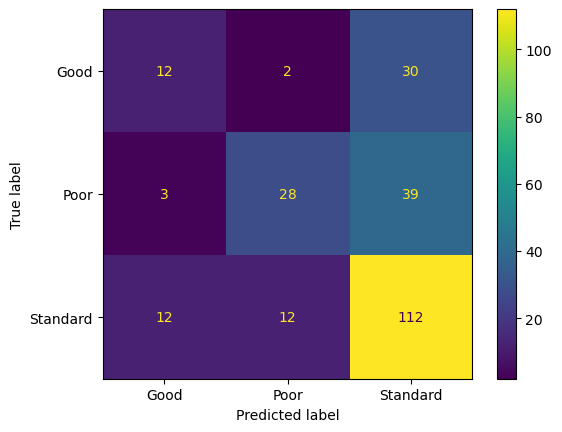

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score

X_test = test[predictors]
y_test = test["Credit_Score"]

ConfusionMatrixDisplay.from_estimator(
    train_fit,
    X_test,
    y_test
)

Accuracy

In [28]:
accuracy = train_fit.score(X_test,y_test)
accuracy

0.608

Precision (number of correct positive predictions per total number of positive predictions)

In [29]:
precision_good = 12/(12 + 2 + 30)
precision_poor = 28/ (3 + 28 + 39)
precision_standard = 112 / (12 + 12 + 112)
print("Precision for good credit score: ", precision_good)
print("Precision for poor credit score: ", precision_poor)
print("Precision for standard credit score: ", precision_standard)

Precision for good credit score:  0.2727272727272727
Precision for poor credit score:  0.4
Precision for standard credit score:  0.8235294117647058


Recall (number of correct positive predictions per total number of positive predictions)

In [30]:
recall_good = 12/(12 + 3 + 12)
recall_poor = 28/ (2 + 28 + 12)
recall_standard = 112 / (30 + 39 + 112)
print("Recall for good credit score: ", recall_good)
print("Recall for poor credit score: ", recall_poor)
print("Recall for standard credit score: ", recall_standard)

Recall for good credit score:  0.4444444444444444
Recall for poor credit score:  0.6666666666666666
Recall for standard credit score:  0.6187845303867403


### Discussion


Outcomes vs expected outcomes:

In our credit score category classification project, we discovered that a k-nearest neighbors (KNN) model with a k-value of 41 yields the highest accuracy of 60.8%. This finding was somewhat anticipated given the nature of our dataset and the typical behavior of KNN models. A moderately high k-value like 41 helps in achieving a balance between overfitting and bias. It's larger than the very small k-values which tend to overfit, but not so large as to introduce significant bias, which can be a problem with very high k-values. This middle ground suggests that our model is less prone to overfitting and is likely to have a smoother decision boundary, making it suitable for larger datasets.

What we found: our predictors (num of delayed payments and days from delayed payments) show a weak positive relation as we would expect. But it is unlikely and hard to find a strong positive relation owing to the difference in behavioural patterns of consumers, however, that discussion is outside the scope of this project. 

We found that Standard credit scores had the highest precision and recall, and this could be due to their unbalanced representation in the data. Although the precision and recall for a Good credit score is not too high, the recall for a Poor or Standard score is higher, which shows that our model is not likely to mislabel a Standard or Poor as Good, which is a good sign.

The impact of these findings is notable in the field of credit scoring. By efficiently predicting creditworthiness with a balanced bias-variance tradeoff, financial institutions can make more informed decisions, potentially reducing the risk of default while offering credit opportunities to eligible individuals.

Potential Shortcomings: investigating the impact of feature selection and data quality on the model's performance could lead to more robust and accurate predictions. Lastly, considering ethical implications and the model's behavior in diverse, real-world scenarios would be essential for responsible application. Since we see that existing research cited discriminates based on credit history age. Additionally, we only used two predictor variables but using multiple variables and studying their interactions is something worth looking into for improving the accuracy of the model. With adding each new predictor, the interaction possibilities grows multiplicatively. So, the process can be time consuming but might yield better results. 


- *What impact could such findings have?*
  - Helping banks predict whether it is a good idea to issue a new credit card to a new user
  - Can influence an individual’s credit limit/interest rate.
  - Studying the relation of individual factors with credit score category classification.
  
- *What future questions could this lead to?* 
  
  How do we evaluate or categorize a new person who has just started working and does not have a long enough credit history. 


### References


- Debt.org. (2023, September 1). Credit Scoring Models: FICO, VantageScore & More. Retrieved from https://www.debt.org/credit/report/scoring-models/                                     
- Akin, J. (2023, July 29). What Affects Your Credit Scores? Experian. https://www.experian.com/blogs/ask-experian/credit-education/score-basics/what-affects-your-credit-scores/